 Zillow 2016 Regression Analysis

## Project Planning

### Goals

*Project Overview
Background:
Zillow wants to improve their Zestimate. The zestimate is estimated value of a home. Zillow theorizes that there is more information to be gained to improve its existing model. Because of that, Zillow wants you to develop a model to predict the error between the Zestimate and the sales price of a home. In predicting the error, you will discover features that will help them improve the Zestimate estimate itself. Your goal of this project is to develop a linear regression model that will best predict the log error of the Zestimate. The error is the difference of the sales price and the Zestimate. The log error is computed by taking the log function of that error. You don't need to worry about the fact that the error is of a logarithmic function. It is a continuous number that represents an error rate.*



### Deliverables

What should the zillow team expect to receive from you?  Again, as you were communicating to them, not to your instructors.  

*your deliverables:*
1. *A report (in the form of a presentation, both verbal and through a slides) that summarizes your findings about the drivers of the Zestimate error. This will come from the analysis you do during the exploration phase of the pipeline. In the report, you will have charts that visually tell the story of what is driving the errors.*

2. *A Jupyter notebook, titled 'Regression_Proj_YourName', that contains a clearly labeled section and code clearly documented for each the stages below (project planning, data acquisition, data prep, exploration, and modeling). All of the work will take place in your jupyter notebook.*

### Data Dictionary & Details

using 2016 data  

### Initial Thoughts, Ideas, Hypotheses

Goal is to predict the features contribution to log error ((measured between sales price and predicted sales price.  We have various features, but not the actual sales price.    

Some initial thoughts on features that may have increased/decreased log error
    1) Extremely large lots.
    2) Older homes.
    3) Time of year of transaction.
    4) Outliers on square footage, bedroom and bathroom count. 
    5) Are there multi-unit dwellings, like condos, townhomes, etc skewing the result
    6) Are some areas (zip code) much more desirable.

### Environment


In [1]:
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, f_classif
from env import user, host, pw, datadirpath
import warnings
warnings.filterwarnings("ignore")

### Data Acquisition - via csv


Make a re-useable list of columns to analyze, call it FeatureList and feed to to pd.read.csv to create the dataframe only containing the needed colums.   Note:  If you decide on different features - change the "FeatureList" and rerun

In [2]:
FeatureList = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','fullbathcnt','garagecarcnt','roomcnt','yearbuilt','taxvaluedollarcnt','taxamount','regionidzip','lotsizesquarefeet','unitcnt']
columnstopull = ['parcelid'] + FeatureList
csvfilename = "properties_2016.csv"
properties = pd.read_csv(datadirpath+csvfilename, usecols=columnstopull)
properties.head()


,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,lotsizesquarefeet,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt,taxamount
0,10754147,0.0,0.0,NaN,NaN,NaN,85768.0,96337.0,0.0,NaN,NaN,9.0,NaN
1,10759547,0.0,0.0,NaN,NaN,NaN,4083.0,96337.0,0.0,NaN,NaN,27516.0,NaN
2,10843547,0.0,0.0,73026.0,NaN,NaN,63085.0,96095.0,0.0,2.0,NaN,1413387.0,20800.37
3,10859147,0.0,0.0,5068.0,NaN,NaN,7521.0,96424.0,0.0,NaN,1948.0,1156834.0,14557.57
4,10879947,0.0,0.0,1776.0,NaN,NaN,8512.0,96450.0,0.0,1.0,1947.0,433491.0,5725.17


In [3]:
csvfilename = "train_2016_v2.csv"
logerrors = pd.read_csv(datadirpath+csvfilename)
logerrors.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


    Using pd.merge on the dataframes and checking for duplicates validate="one_to_one",   there are duplicates
use pd.concat to find out how many duplicated parcelids.    There are 249 duplicated parcelid s
    Inspection of the duplicates indicates that these are corrected rows, with a later transaction date always occuring on the last duplicate.   

In [4]:
pd.concat(dupes for _, dupes in logerrors.groupby("parcelid") if len(dupes) > 1)

,parcelid,logerror,transactiondate
10828,10736972,-0.0460,2016-02-22
10829,10736972,-0.0367,2016-12-14
9177,10790468,-0.0450,2016-02-12
9178,10790468,-0.0440,2016-09-13
2226,10796614,-0.1267,2016-01-13
2227,10796614,-0.0704,2016-06-14
24522,10798910,-0.0471,2016-04-12
24523,10798910,-0.0274,2016-05-24
6291,10799924,0.0478,2016-01-29
6292,10799924,0.4121,2016-08-09


Now remove the duplicates (keeping the last occurance) based on parcel id

In [5]:
logerrors.drop_duplicates(subset='parcelid', keep='last', inplace=True)

  and merge the two dataframes, checking for duplicates 

In [6]:
frames = [properties, logerrors]
df = pd.merge(properties, logerrors, on='parcelid', how='inner', validate="one_to_one")
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,lotsizesquarefeet,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt,taxamount,logerror,transactiondate
0,17073783,2.5,3.0,1264.0,2.0,2.0,1735.0,97081.0,5.0,NaN,1986.0,191811.0,2015.06,0.0953,2016-01-27
1,17088994,1.0,2.0,777.0,1.0,1.0,NaN,97083.0,4.0,NaN,1990.0,239679.0,2581.30,0.0198,2016-03-30
2,17100444,2.0,3.0,1101.0,2.0,2.0,6569.0,97113.0,5.0,NaN,1956.0,47853.0,591.64,0.0060,2016-05-27
3,17102429,1.5,2.0,1554.0,1.0,2.0,7400.0,97113.0,5.0,NaN,1965.0,62914.0,682.78,-0.0566,2016-06-07
4,17109604,2.5,4.0,2415.0,2.0,2.0,6326.0,97084.0,8.0,NaN,1984.0,554000.0,5886.92,0.0573,2016-08-08


### Data Preparation

Goal: leave this section with a dataset that is ready to be analyzed. 

#### Create a variable, `colnames`, that is a list of the column names. 
Why? You will likely reference this variable later.

In [7]:
colnames = FeatureList
colnames

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'garagecarcnt',
 'roomcnt',
 'yearbuilt',
 'taxvaluedollarcnt',
 'taxamount',
 'regionidzip',
 'lotsizesquarefeet',
 'unitcnt']

#### Identify the data types of each variable. Why? 
You need to make sure they are what makes sense for the data and the meaning of the data that lies in that variable. If it does not, make necessary changes.

In [8]:
df.describe()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,garagecarcnt,lotsizesquarefeet,regionidzip,roomcnt,unitcnt,yearbuilt,taxvaluedollarcnt,taxamount,logerror
count,9.015000e+04,90150.000000,90150.000000,89492.000000,88974.000000,29897.000000,8.001400e+04,90115.000000,90150.000000,58271.000000,89397.000000,9.014900e+04,90144.000000,90150.000000
mean,1.298488e+07,2.279545,3.031936,1773.096869,2.241172,1.812055,2.912064e+04,96586.196216,1.478580,1.110244,1968.539761,4.576379e+05,5983.070888,0.011526
std,2.505517e+06,1.004133,1.156114,928.136339,0.963106,0.608865,1.217909e+05,3663.847246,2.819802,0.797389,23.763165,5.548532e+05,6838.506814,0.160968
min,1.071174e+07,0.000000,0.000000,2.000000,1.000000,0.000000,1.670000e+02,95982.000000,0.000000,1.000000,1885.000000,2.200000e+01,49.080000,-4.605000
25%,1.155970e+07,2.000000,2.000000,1184.000000,2.000000,2.000000,5.704000e+03,96193.000000,0.000000,1.000000,1953.000000,1.990560e+05,2873.260000,-0.025300
50%,1.254744e+07,2.000000,3.000000,1540.000000,2.000000,2.000000,7.200000e+03,96393.000000,0.000000,1.000000,1970.000000,3.429310e+05,4543.100000,0.006000
75%,1.422757e+07,3.000000,4.000000,2095.000000,3.000000,2.000000,1.168175e+04,96987.000000,0.000000,1.000000,1987.000000,5.405890e+05,6900.165000,0.039200
max,1.629608e+08,20.000000,16.000000,22741.000000,20.000000,24.000000,6.971010e+06,399675.000000,18.000000,143.000000,2015.000000,2.775000e+07,321936.090000,4.737000


Cleanup Steps

#### Identify the columns that have missing values and the number of missing values in each column. 


1) drop column "garagecarcnt' completly because only one-third of the rows have values 
2) drop rows containing null values, about 10k              
3) Drop rows where calculatedfinishedsquarefeet <= 300 square feet (not reasonable)
4) eliminate roomcnt as a column, values don't look correct (min, IQR nonsensical)  
5) add column called logerrorabs to account for negative log errors
6) add column called bedbathcount, which is aggregation of bedroomcount + bathroomcount
7) use unitcnt to filter out any rows from multi-family dwellings (unitcnt > 1)
8) Create a new column called sales_month, which is the month the sales transaction occured
9) Drop rows with extreme outliers in calculatedfinishedsquarefeet (above 7500sq ft)
10) Trim out zip code id s that are out of reagion, or obviously a mistake
11) After filtering duplicates plus above, we are left with 50k rows (down from 90k)
           

In [9]:
df.drop(columns=['garagecarcnt'], inplace=True)

In [10]:
df.drop(columns=['roomcnt'], inplace=True)

In [11]:
indexNames = df[ (df['unitcnt'] > 1) ].index
df.drop(indexNames , inplace=True)

In [12]:
df.drop(columns=['unitcnt'], inplace=True)

In [13]:
df['parcelid'] = df['parcelid'].apply(lambda x: "{:.0f}".format(x) if x is not None else x)

In [14]:
# df['regionidzip'] = df['regionidzip'].apply(lambda x: "z"+"{:.0f}".format(x) if x is not None else x)
# wanted to make zipcode a string, but too many seaborn problems plotting it

In [15]:
# df['yearbuilt'] = df['yearbuilt'].apply(lambda x: "y"+"{:.0f}".format(x) if x is not None else x)
# wanted to make yearbuilt a string, but too many seaborn problems plotting it

In [16]:
indexNames = df[ (df['calculatedfinishedsquarefeet'] <= 300) ].index
df.drop(indexNames , inplace=True)

In [17]:
df['bedbathcnt'] = df['bedroomcnt'] + df['bathroomcnt']  

In [18]:
df['logerrorabs'] = df['logerror'].abs()

In [19]:
df['sales_month'] = pd.to_numeric(df['transactiondate'].str.slice(5,7))

In [20]:
indexNames = df[ (df['calculatedfinishedsquarefeet'] > 7500) ].index
df.drop(indexNames , inplace=True)

In [21]:
indexNames = df[ (df['lotsizesquarefeet'] > 65_340) ].index
df.drop(indexNames , inplace=True)

In [22]:
df.dropna(how='any',axis=0, inplace=True)

In [23]:
indexNames = df[ (df['bedbathcnt'] > 15) ].index
df.drop(indexNames , inplace=True)

In [24]:
indexNames = df[ (df['logerrorabs'] > .25) ].index
df.drop(indexNames , inplace=True)

In [25]:
indexNames = df[ (df['taxvaluedollarcnt'] > 5_000_000) ].index
df.drop(indexNames , inplace=True)

In [26]:
indexNames = df[ (df['regionidzip'] > 96987) ].index
df.drop(indexNames , inplace=True)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49728 entries, 12 to 90148
Data columns (total 15 columns):
parcelid                        49728 non-null object
bathroomcnt                     49728 non-null float64
bedroomcnt                      49728 non-null float64
calculatedfinishedsquarefeet    49728 non-null float64
fullbathcnt                     49728 non-null float64
lotsizesquarefeet               49728 non-null float64
regionidzip                     49728 non-null float64
yearbuilt                       49728 non-null float64
taxvaluedollarcnt               49728 non-null float64
taxamount                       49728 non-null float64
logerror                        49728 non-null float64
transactiondate                 49728 non-null object
bedbathcnt                      49728 non-null float64
logerrorabs                     49728 non-null float64
sales_month                     49728 non-null int64
dtypes: float64(12), int64(1), object(2)
memory usage: 6.1+ MB


#### Create a list of the independent variable names (aka attributes) and assign it to `x_vars` 
Why? During exploration, you will likely use this list to refer to the attribute names.

In [28]:
x_vars = ['calculatedfinishedsquarefeet','lotsizesquarefeet','regionidzip','yearbuilt','taxvaluedollarcnt','sales_month','bedbathcnt']


#### Clearly identify your dependent (target) variable. 
- What is the name of the variable? 
- Is it discrete or continuous?

The dependent variable is logerror,  it is continuous. 

#### View the distribution of the numeric variables
- plot a histogram and box plot of each variable. 
- Why? To see the distribution, skewness, outliers, and unit scales. You will use this information in your decision of whether to normalize, standardize or neither.

Drop out the columns we didn't see any relationship on (that we used mostly for filtering)

Drop columns (iteration from OLS step below)

In [29]:
df.drop(columns=['bathroomcnt'], inplace=True)
df.drop(columns=['taxamount'], inplace=True)
df.drop(columns=['transactiondate'], inplace=True)

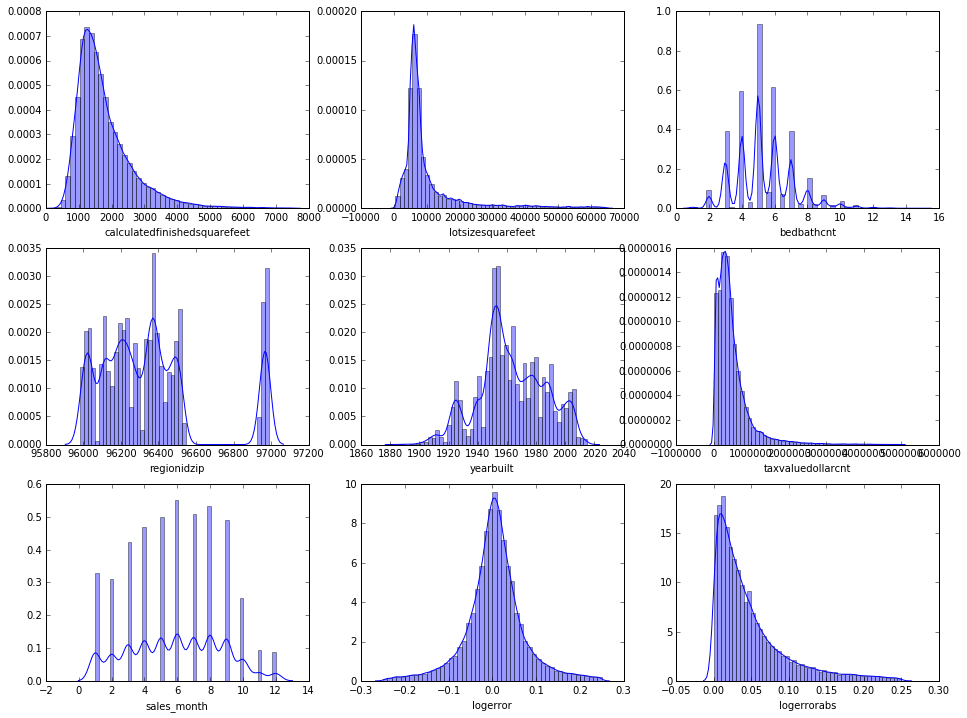

In [30]:
plt.figure(figsize=(16,12))
plt.subplot(3,3,1)
sns.distplot(df.calculatedfinishedsquarefeet)
plt.subplot(3,3,2)
sns.distplot(df.lotsizesquarefeet)
plt.subplot(3,3,3)
sns.distplot(df.bedbathcnt)
plt.subplot(3,3,4)
sns.distplot(df.regionidzip)
plt.subplot(3,3,5)
sns.distplot(df.yearbuilt)
plt.subplot(3,3,6)
sns.distplot(df.taxvaluedollarcnt)
plt.subplot(3,3,7)
sns.distplot(df.sales_month)
plt.subplot(3,3,8)
sns.distplot(df.logerror)
plt.subplot(3,3,9)
sns.distplot(df.logerrorabs)
plt.show()


#### BONUS:  Data standardization 
Create a new data frame that is the min-max normalization of the independent variable in the original data frame (+ the original dependent variable). You will normalize each of the numeric independent variables independently, i.e. using the min and max of each variable, not the min/max of the whole dataframe. Why? Regression is very sensitive to difference in units. It will be almost impossible to extract a meaningful linear regression model with such extreme differences in scale. For more context, see: https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc
You will use this dataframe in the future analysis.

### Data Exploration

Goal is to address each of the questions you posed in your planning & brainstorming through visual or statistical analysis.

When you have completed this step, you will have the findings from your analysis that will be used in your final report, the answers to your questions and your customer's questions that will reach the goal. 

#### Split data into training and test datasets
   

In [31]:
df.drop(columns=['fullbathcnt'], inplace=True)
df.drop(columns=['bedroomcnt'], inplace=True)
df.drop(columns=['sales_month'], inplace=True)
df.drop(columns=['taxvaluedollarcnt'], inplace=True)

In [32]:
X = df.drop(['parcelid'], axis=1)
y = df[['logerror']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=123)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

#### Create a jointplot for each independent variable (normalized version) with the dependent variable. 

Be sure you have Pearson's r and p-value annotated on each plot.

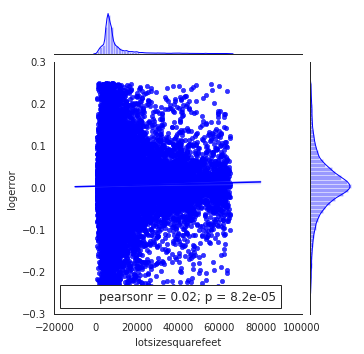

In [33]:
with sns.axes_style('white'):
         j = sns.jointplot( "lotsizesquarefeet", "logerror", data=X_train, kind='reg', height=5);
         j.annotate(stats.pearsonr) 


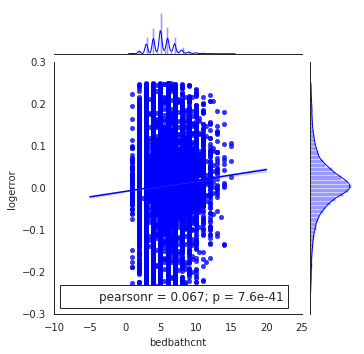

In [34]:
with sns.axes_style('white'):
         j = sns.jointplot( "bedbathcnt", "logerror", data=X_train, kind='reg', height=5);
         j.annotate(stats.pearsonr) 


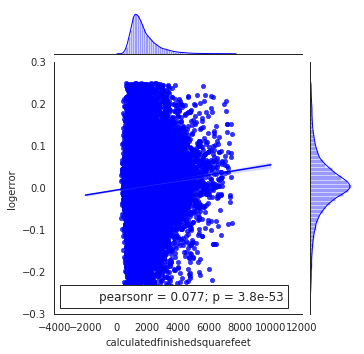

In [35]:
with sns.axes_style('white'):
         j = sns.jointplot( "calculatedfinishedsquarefeet", "logerror", data=X_train, kind='reg', height=5);
         j.annotate(stats.pearsonr) 


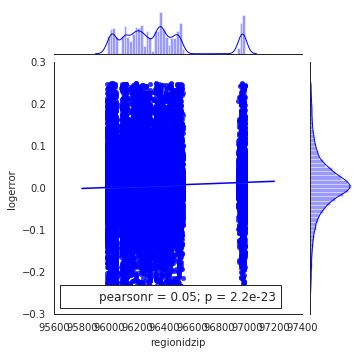

In [36]:
with sns.axes_style('white'):
         j = sns.jointplot( "regionidzip", "logerror", data=X_train, kind='reg', height=5);
         j.annotate(stats.pearsonr) 


#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 

You may want to use a normalized dataframe (if you did that) or adjust the axis scale (set to logarithmic, e.g) so you can more clearly view the interactions.

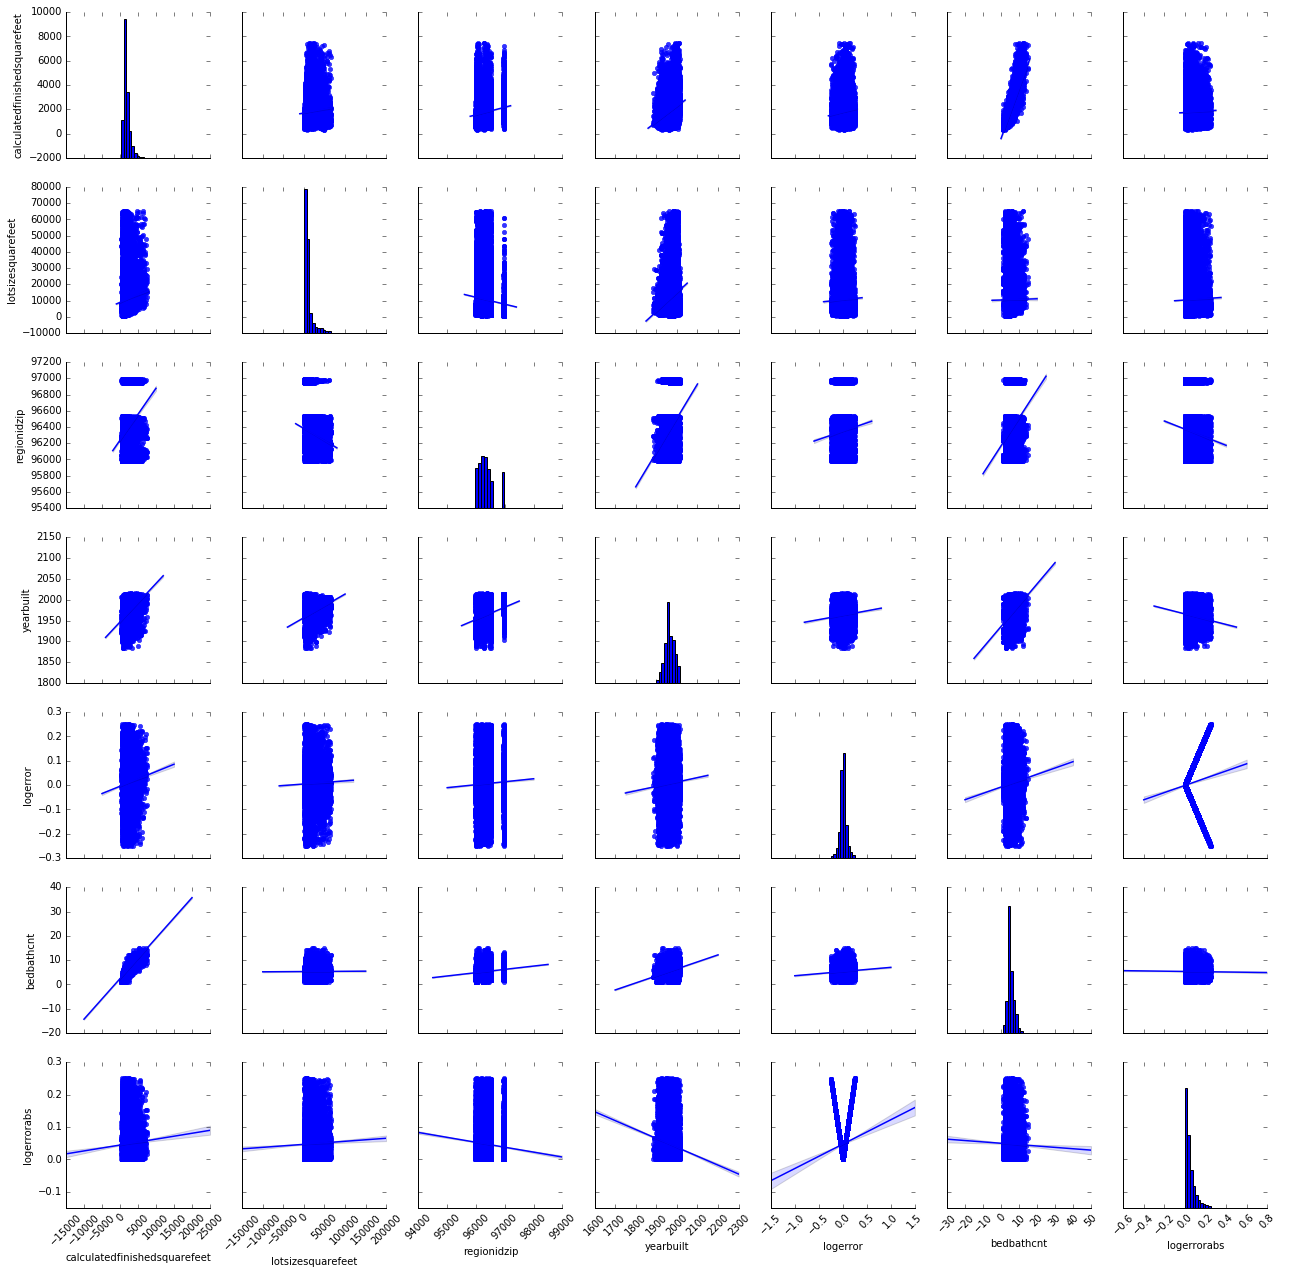

In [37]:
g = sns.PairGrid(X_train) 
g.map_upper(sns.regplot) 
g.map_lower(sns.regplot) 
# g.map_lower(sns.residplot) 
g.map_diag(plt.hist) 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45) 
g.add_legend() 
g.set(alpha=0.5)

#### Create a heatmap of the correlation between each variable pair.

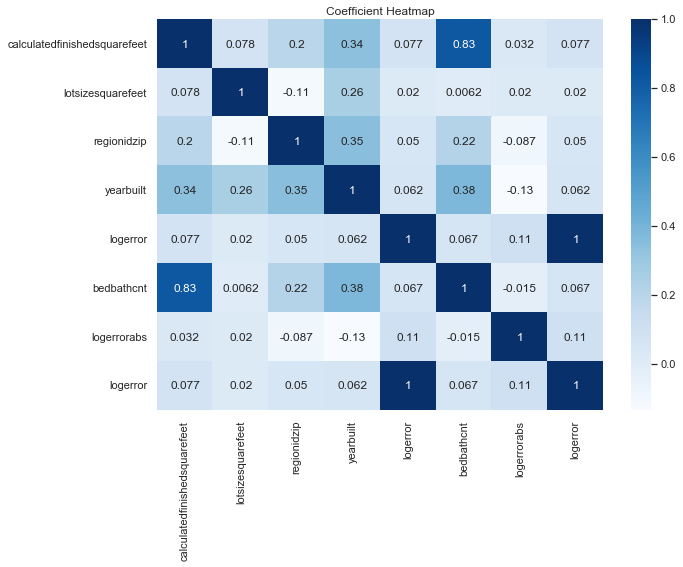

In [38]:
plt.figure(figsize=(10,7))
sns.set(style="whitegrid")
plt.title('Coefficient Heatmap')
sns.heatmap(train.corr(), cmap='Blues', annot=True)

In [39]:
column_names = X_train.columns
r_and_p_values = [pearsonr(X_train[col], y_train.logerror) for col in column_names]
total_charges_corr_dict = dict(zip(column_names, r_and_p_values))
total_charges_corr_dict


{'calculatedfinishedsquarefeet': (0.07682345349640023, 3.827758974704055e-53),
 'lotsizesquarefeet': (0.019745764060436946, 8.194584118710248e-05),
 'regionidzip': (0.04992282754612627, 2.207936785591052e-23),
 'yearbuilt': (0.06180240711014035, 5.643044689775908e-35),
 'logerror': (1.0, 0.0),
 'bedbathcnt': (0.06702523462273267, 7.591544529767904e-41),
 'logerrorabs': (0.1055381384405798, 6.667450121950235e-99)}

#### Summarize your conclusions from all of these steps.  

The best correlations with the Zillow log error belong to the Year the home was built and also to the lot size. Behind that, tax value and finished square feet have some correlation to log error as well (but that could simply be a virtue of higher sales values generate a larger correlation error, which makes sense). 

Are there any data sets that show a sinificant difference in log error (or log error abs) between the upper and lower ranges ? 
Null hypothesis is that each of the sets below do not have significant differences.   A high t-value and low p-value indicates that the null hypothesis is not true, and that each of these groups has significant statistical differences from each other that is not likely due to chance (with regard to log error).  Of these,  lot size has the lease impact,  but it is still a signifcant factor in log error.


 Some results; 
 
     Zipcode   - 96400 and lower versus 96400 higher
     Conclusion: There is a significant difference in Zip code areas.
     (on logerror)  
         t-value = -9.24,     p = 2.4x10e-20
         
     Bedroom Count .  3 bedroom versus 5 bedrooms
     Conclusion: There is a significant difference in the samples based on bedroom count.
     (on logerror)  
         t-value = -11.04,    p = 2.74x10e-28    
 
     Lot Size .  - less than 15,000 sq feet versus gt 15,000 square feet
     Conclusion: There is a significant difference in the samples based on lot size.
     (on logerror)  
         t-value = -4.78,      p = 1.69x10e-6  
        
     Year Built.  - pre 1970 versus post 1970
     Conclusion: There is a significant difference in the samples based on year built.
     (on logerror)  
         t-value = -11.3,     p = 1.36x10e-29         

In [41]:
#  run for each set
# lt3_df = df[(df['lotsizesquarefeet'] < 15_000)]
# gt5_df = df[(df['lotsizesquarefeet'] > 15_000)]
# x1 = lt3_df.iloc[:,[8]].as_matrix()
# x2 = gt5_df.iloc[:,[8]].as_matrix()

In [ ]:
# stats.ttest_ind(x1,x2)

### Data Modeling

#### Feature Engineering & Selection

#### Are there new features you could create based on existing features that might be helpful? 

Come up with at least one possible new feature that is a calculation from 2+ existing variables. 

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

#### Summarize your conclusions and next steps from your analysis in above. 
What will you try when developing your model? (which features to use/not use/etc)

#### Train & Test Model

#### Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

- Make any changes as necessary to improve your model.

- Identify the best model after all training

- Compare the models by plotting the predictions of each model with actual values (see plot right above section 12 in 'Regression in Python' lesson

#### Predict & evaluate on out-of-sample data (test)    

- Plot the residuals from your out-of-sample predictions.

- Summarize your expectations about how you estimate this model will perform in production.

In [42]:
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logerror   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.814e+29
Date:                Tue, 26 Mar 2019   Prob (F-statistic):               0.00
Time:                        09:05:52   Log-Likelihood:             1.2451e+06
No. Observations:               39782   AIC:                        -2.490e+06
Df Residuals:                   39775   BIC:                        -2.490e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
calculatedfinishedsquarefeet   1.06e-17   6.47e-20    163.788      0.000    1.05e-17    1.07e-17
lotsizesquarefeet            -8.072e-20   3.16e-21    -25.579      0.000   -8.69e-20   -7.45e-20
regionidzip                  -6.643e-19   3.27e-20    -20.312      0.000   -7.28e-19      -6e-19
yearbuilt                     4.108e-17   1.63e-18     25.255      0.000    3.79e-17    4.43e-17
logerror                         1.0000   4.64e-16   2.16e+15      0.000       1.000       1.000
bedbathcnt                   -6.484e-15   3.27e-17   -198.522      0.000   -6.55e-15   -6.42e-15
logerrorabs                  -1.275e-16   6.57e-16     -0.194      0.846   -1.42e-15    1.16e-15
==============================================================================
Omnibus:                      851.665   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1919.379
Skew:                           0.002   Prob(JB):                         0.00
Kurtosis:                       4.076   Cond. No.                     2.06e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Remove fullbathcnt, bedroomcnt, taxvaluedollarcant, and sales_month and re-split (go back to previous steps)

Create 5 models and see which one is best (comparing mse)
lm1 is calculated finished square feet, lotsize squarefeet, regionidzip, yearbuilt, and bedbathcnt
lm2 is calculated finished square feet, regionidzip, yearbuilt, and bedbathcnt    

In [57]:
lm1 = LinearRegression(fit_intercept=False) 

In [58]:
lm1.fit(X_train[['calculatedfinishedsquarefeet','bedbathcnt','yearbuilt','regionidzip','lotsizesquarefeet']], y_train)
lm1_y_intercept = lm1.intercept_
lm1_coefficients = lm1.coef_


In [59]:
y_pred_lm1 = lm1.predict(X_train[['calculatedfinishedsquarefeet','bedbathcnt','yearbuilt','regionidzip','lotsizesquarefeet']])


In [60]:
mse_lm1 = mean_squared_error(y_train, y_pred_lm1)
r2_lm1 = r2_score(y_train, y_pred_lm1)

In [61]:
lm2 = LinearRegression(fit_intercept=False) 

In [62]:
lm2.fit(X_train[['calculatedfinishedsquarefeet','bedbathcnt','yearbuilt','regionidzip',]], y_train)
lm2_y_intercept = lm2.intercept_
lm2_coefficients = lm2.coef_


In [63]:
y_pred_lm2 = lm2.predict(X_train[['calculatedfinishedsquarefeet','bedbathcnt','yearbuilt','regionidzip']])
mse_lm2 = mean_squared_error(y_train, y_pred_lm2)
r2_lm2 = r2_score(y_train, y_pred_lm2)

In [64]:
lm3 = LinearRegression(fit_intercept=False)

In [65]:
lm3.fit(X_train[['calculatedfinishedsquarefeet','bedbathcnt','yearbuilt']], y_train)
lm3_y_intercept = lm3.intercept_
lm3_coefficients = lm3.coef_


In [66]:
y_pred_lm3 = lm3.predict(X_train[['calculatedfinishedsquarefeet','bedbathcnt','yearbuilt']])
mse_lm3 = mean_squared_error(y_train, y_pred_lm3)
r2_lm3 = r2_score(y_train, y_pred_lm3)

In [67]:
lm4 = LinearRegression(fit_intercept=False)

In [68]:
lm4.fit(X_train[['bedbathcnt','yearbuilt','regionidzip']], y_train)
lm4_y_intercept = lm3.intercept_
lm4_coefficients = lm3.coef_


In [69]:
y_pred_lm4 = lm4.predict(X_train[['bedbathcnt','yearbuilt','regionidzip']])
mse_lm4 = mean_squared_error(y_train, y_pred_lm4)
r2_lm4 = r2_score(y_train, y_pred_lm3)

In [56]:
print("Model 1 lm1:    mse: {:.3} R2 score: {:.2%}".format(mse_lm1, r2_lm1)) 
print("Model 2 lm2:    mse: {:.3} R2 score: {:.2%}".format(mse_lm2, r2_lm2)) 
print("Model 3 lm3:    mse: {:.3} R2 score: {:.2%}".format(mse_lm3, r2_lm3)) 
print("Model 4 lm4:    mse: {:.3} R2 score: {:.2%}".format(mse_lm4, r2_lm4)) 

Model 1 lm1:    mse: 0.00453 R2 score: 0.68%
Model 2 lm2:    mse: 0.00453 R2 score: 0.68%
Model 3 lm2:    mse: 0.00453 R2 score: 0.59%
Model 4 lm2:    mse: 0.00453 R2 score: 0.59%


In [ ]:
pd.DataFrame({'bedbathcnt': X_test.bedbathcnt,
             'logerror':  y_test.logerror})
sns.regplot(data=test, x=X_test.bedbathcnt, y=y_test.logerror, color='b')

plt.ylim(-0.3, 0.3)
plt.xlim(0, 16)
plt.title('Predicted vs Actual logerror using bedbathcnt')

In [ ]:
lm2 = LinearRegression(fit_intercept=False) 

In [ ]:
lm2.fit(X_train[['yearbuilt']], y_train)
lm2_y_intercept = lm2.intercept_
lm2_coefficients = lm2.coef_
print('Train model Univariate - log error = b + m * yearbuilt')
print('    y-intercept (b): %.2f' % lm2_y_intercept)
print('    coefficient (m): %.2f' % lm2_coefficients[0])

In [ ]:
y_pred_lm2 = lm2.predict(X_train[['yearbuilt']])

In [ ]:
pd.DataFrame({'yearbuilt': X_test.yearbuilt,
             'logerror':  y_test.logerror})
sns.regplot(data=test, x=X_test.yearbuilt, y=y_test.logerror, color='b')

plt.ylim(-0.3, 0.3)
plt.xlim(1960, 2020)
plt.title('Predicted vs Actual logerror using yearbuilt')

In [ ]:
lm3 = LinearRegression(fit_intercept=False) 

In [ ]:
lm3.fit(X_train[['lotsizesquarefeet']], y_train)
lm3_y_intercept = lm3.intercept_
lm3_coefficients = lm3.coef_
print('Train model Univariate - log error = b + m * lotsizesquarefeet')
print('    y-intercept (b): %.2f' % lm3_y_intercept)
print('    coefficient (m): %.2f' % lm3_coefficients[0])

In [ ]:
y_pred_lm3 = lm3.predict(X_train[['lotsizesquarefeet']])

In [ ]:
pd.DataFrame({'lotsizesquarefeet': X_test.lotsizesquarefeet,
             'logerror':  y_test.logerror})
sns.regplot(data=test, x=X_test.lotsizesquarefeet, y=y_test.logerror, color='b')

plt.ylim(-0.3, 0.3)
plt.xlim(3000, 10000)
plt.title('Predicted vs Actual logerror using lotsizesquarefeet')